In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

IE=1.

class CableEquation(object):
    
    def __init__(self, rL=200., rm=20., a=2., Ie=10.):
        """ 
        Initializes a CableEquation object.
        
        :param rL: (default=200.) intracellular resistivity [Ohm*cm]
        :param rm: (default=20.) specific membrane resistance [kOhm*cm]
        :param a: (default=2.) cable diameter [um]
        :param Ie: total injected current [nA]
        """
        self.rL = rL
        self.rm = rm
        self.a = a
        self.Ie = Ie
        self.l = np.sqrt( rm*a / (2*rL) ) # electronic length constant lambda
        self.Rl = self.l*rL / (np.pi*a**2) # input resistance

        
    def system_of_ODEs(self, y, x):
        """ 
        Define system of ordinary differential equations to solve with odeint. 
        Transform 
            dv^2/dx^2 = 2*rL/a * (v/rm - ie)
        into
            ode0 = dv/dx + theta(x_inj) * 2*ie*rL/a
            ode1 = d(ode0)/dx = dv^2/dx^2 = 2*rL*v/(a*rm)
        or
            ode0 = dv/dx
            ode1 = d(ode0)/dx = dv^2/dx^2 = 2*rL/a * (v/rm - ie)
        
        :param y: tuple with y[0]=v and y[1]=dv/dx of previous location
        :param x: new location to evaluate ODEs
        """
        #TODO: we are using total injected current Ie, but in the diff.eq. 
        # the current per unit area is used! problem dx->0
        Ie = self.Ie if x>0 else 0.
        ode0 = y[1] + 2 * self.Ie * self.rL / self.a
        ode1 = 2 * self.rL * y[0] / (self.a * self.rm)
        return [ode0, ode1]
    
    def solve_numerically(self, x_grid, v0=0., dvdx0=0.):
        solution = odeint(self.system_of_ODEs, (v0,dvdx0), x_grid) 
        # normalization and scaling to compare with analytical solution
        self.x = x_grid
        self.v_numerical = solution[:,0] / np.max(solution[:,0]) * self.Ie * self.Rl / 2
        
    def solve_analytically(self, x_grid):
        self.x = x_grid
        self.v_analytical = self.Ie * self.Rl / 2 * np.exp(-np.abs(x_grid) / self.l)
     
    def plot_results(self, x_grid=None, ax=None, solve_new=False):
        if solve_new:
            self.solve_analytically(x_grid)
            self.solve_numerically(x_grid)
        if not ax:
            ax = plt.gca()
        ax.plot(self.x, self.v_numerical, label='numerical')
        ax.plot(self.x, self.v_analytical, label='analytical')
        ax.set_title('Solution of cable equation for infinite cable\nand current injection at $x=0$')
        ax.set_xlabel(r'$x/\lambda$')
        ax.set_ylabel(r'$2v(x)/I_eR_{\lambda}$')
        ax.legend()
        
    def plot_initial_condition_sweep(self, x_grid, v0, dvdx0):
        fig, ax = plt.subplots(len(v0), len(dvdx0), figsize=(len(v0)*4, len(dvdx0)*4))
        for i,y in enumerate(v0):
            for j,dy in enumerate(dvdx0):
                self.plot_results(x_grid=x_grid, ax=ax[i,j], solve_new=True)
                ax[i,j].set_title('y={}, dy={}'.format(y, dy))

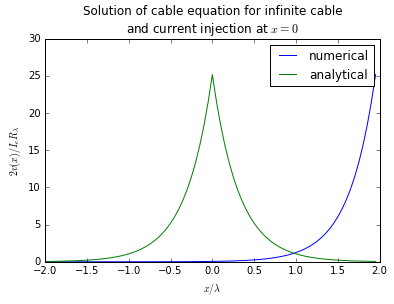

In [174]:
cable = CableEquation()
x = np.arange(-2,2,0.05)
cable.solve_analytically(x)
cable.solve_numerically(x)
cable.plot_results()

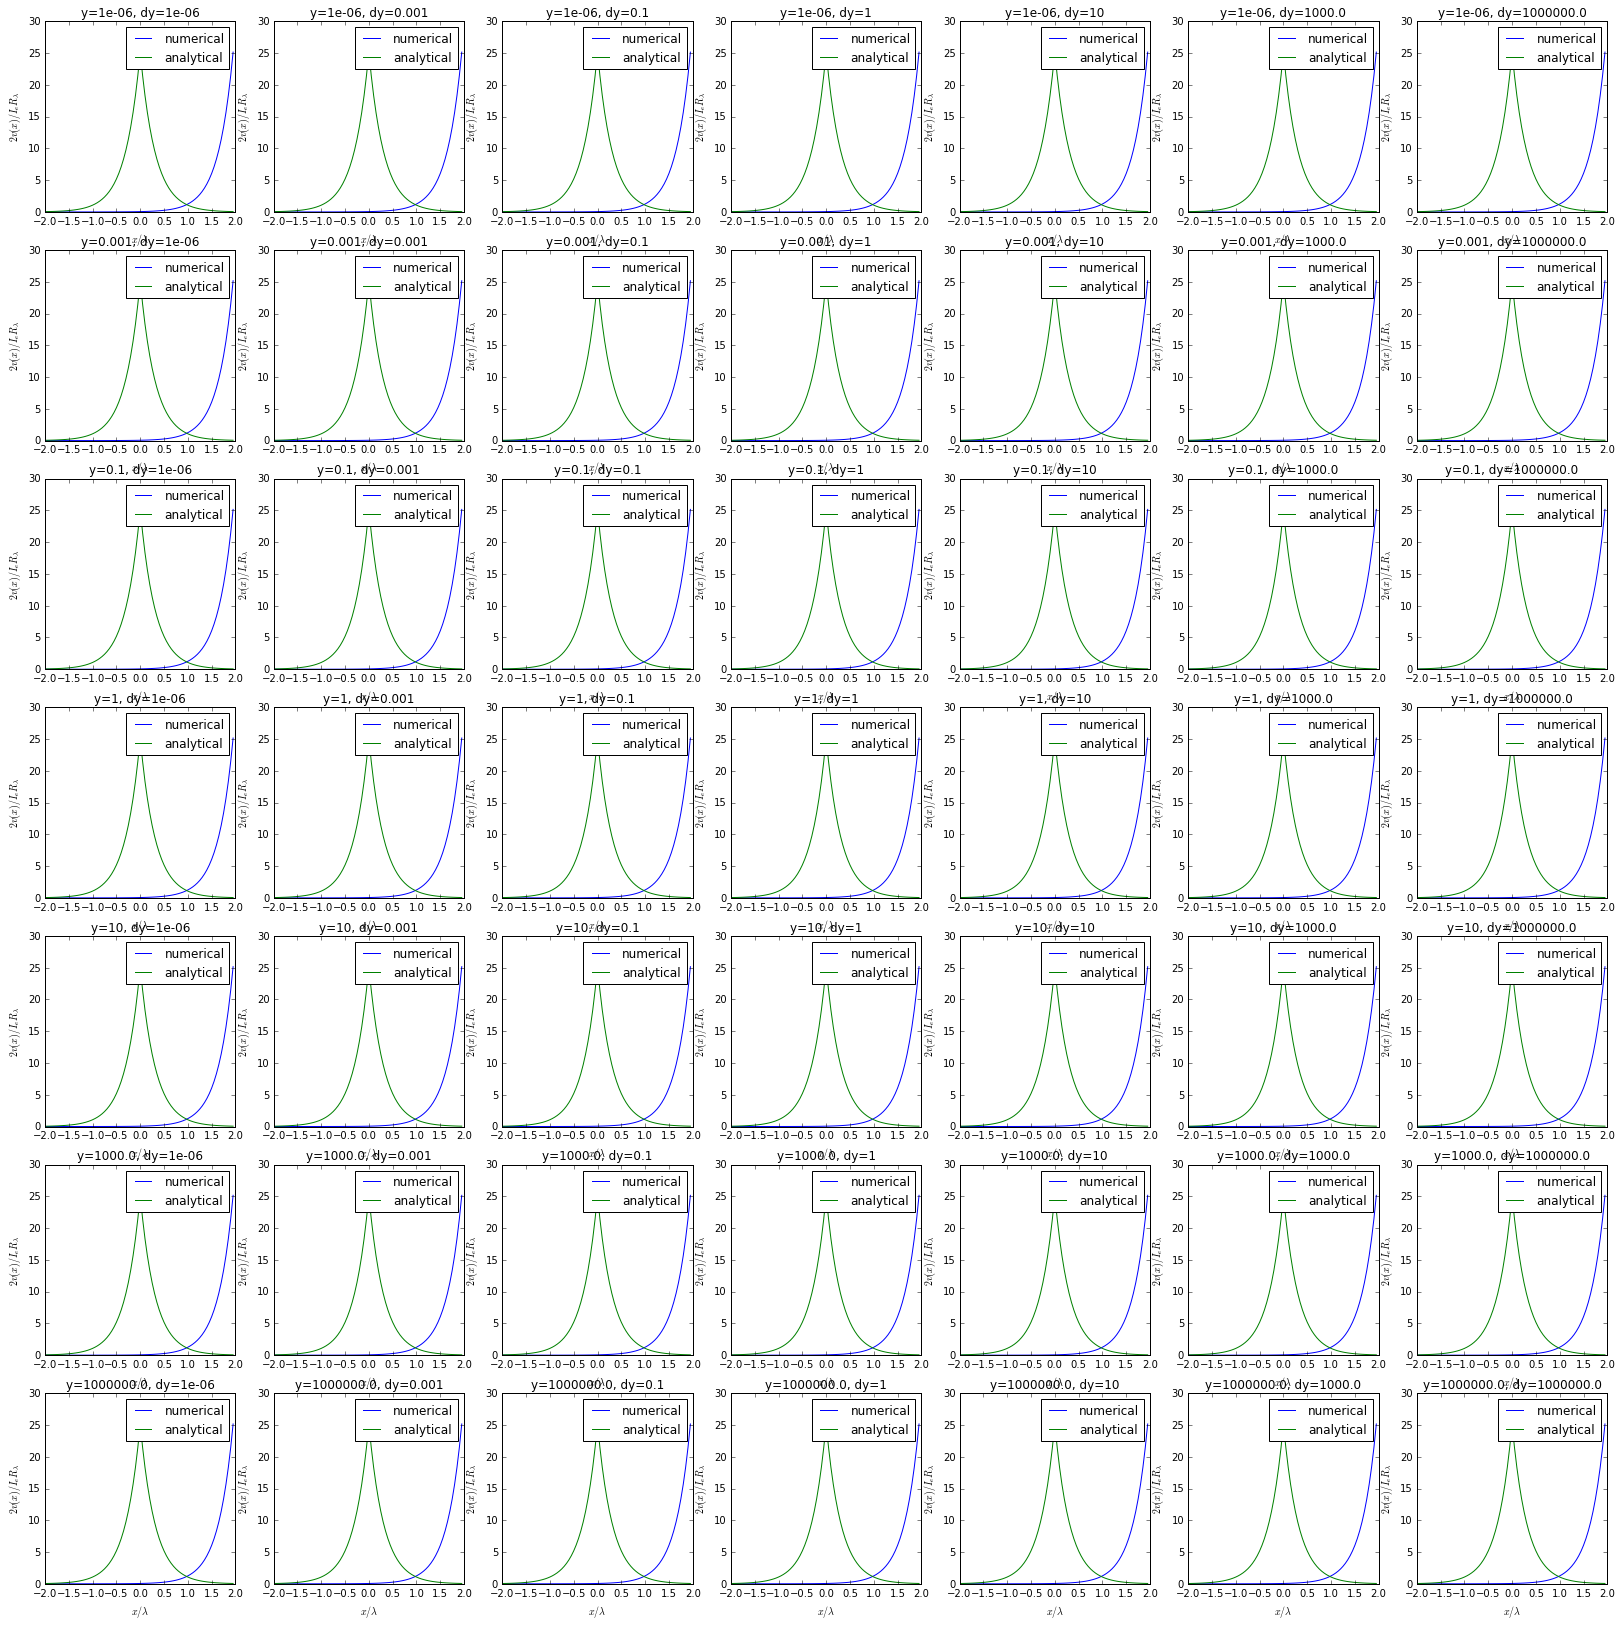

In [175]:
values = [1e-6, 1e-3, 0.1, 1, 10, 1e3, 1e6]
x = np.arange(-2,2,0.05)
cable.plot_initial_condition_sweep(x, values, values)

In [169]:
def steady_cable_equation(V, X, rL=200., eL=0., rm=20., a=2., ie=IE):
        """
        functions to pass to odeint
        args:
            V: tuple
            rL: intracellular resistivity [Ohm*cm]
            eL: leak potential [mV]
            rm: specific membrane resistance [kOhm*cm]
            a: diameter [um]
        """
        IE=0.
        if X>0.5:
#             if X<2.5:
                IE=ie
                
#         IE = ie if X>0.5 and X<2.5 else 0.
#         print IE
        y = V[1] + IE*2*rL/a
        dydx = 2*rL/a*( (V[0]-eL)/rm)
#         y = V[1]
#         dydx = 2*rL/a * (V[0]/rm - IE)
#         print ode1
#         print ode2
#         print ''
              
        return [y, dydx]
        

def analytical_steady_cable(x, rL=200., eL=-54.502, rm=20., a=2., ie=IE):
    lam = np.sqrt(a*rm/(2*rL))
    Rlam = rL*lam/(np.pi*a**2)
    return ie*Rlam/2*np.exp(-np.abs(x)/lam)

In [145]:
B = IE*200*np.sqrt(2.*20/(2.*200))/(np.pi*2**2)/2
x = np.arange(-2,2,0.05) # cm
lam = np.sqrt(2*20./(2*200.))
v = odeint(steady_cable_equation, (0,0), x) 
v = v / v[-1] * B

v_analytical = analytical_steady_cable(x)

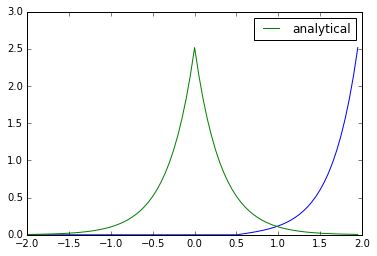

In [146]:
plt.plot(x,v[:,0])
plt.plot(x, v_analytical, label='analytical')
plt.legend()

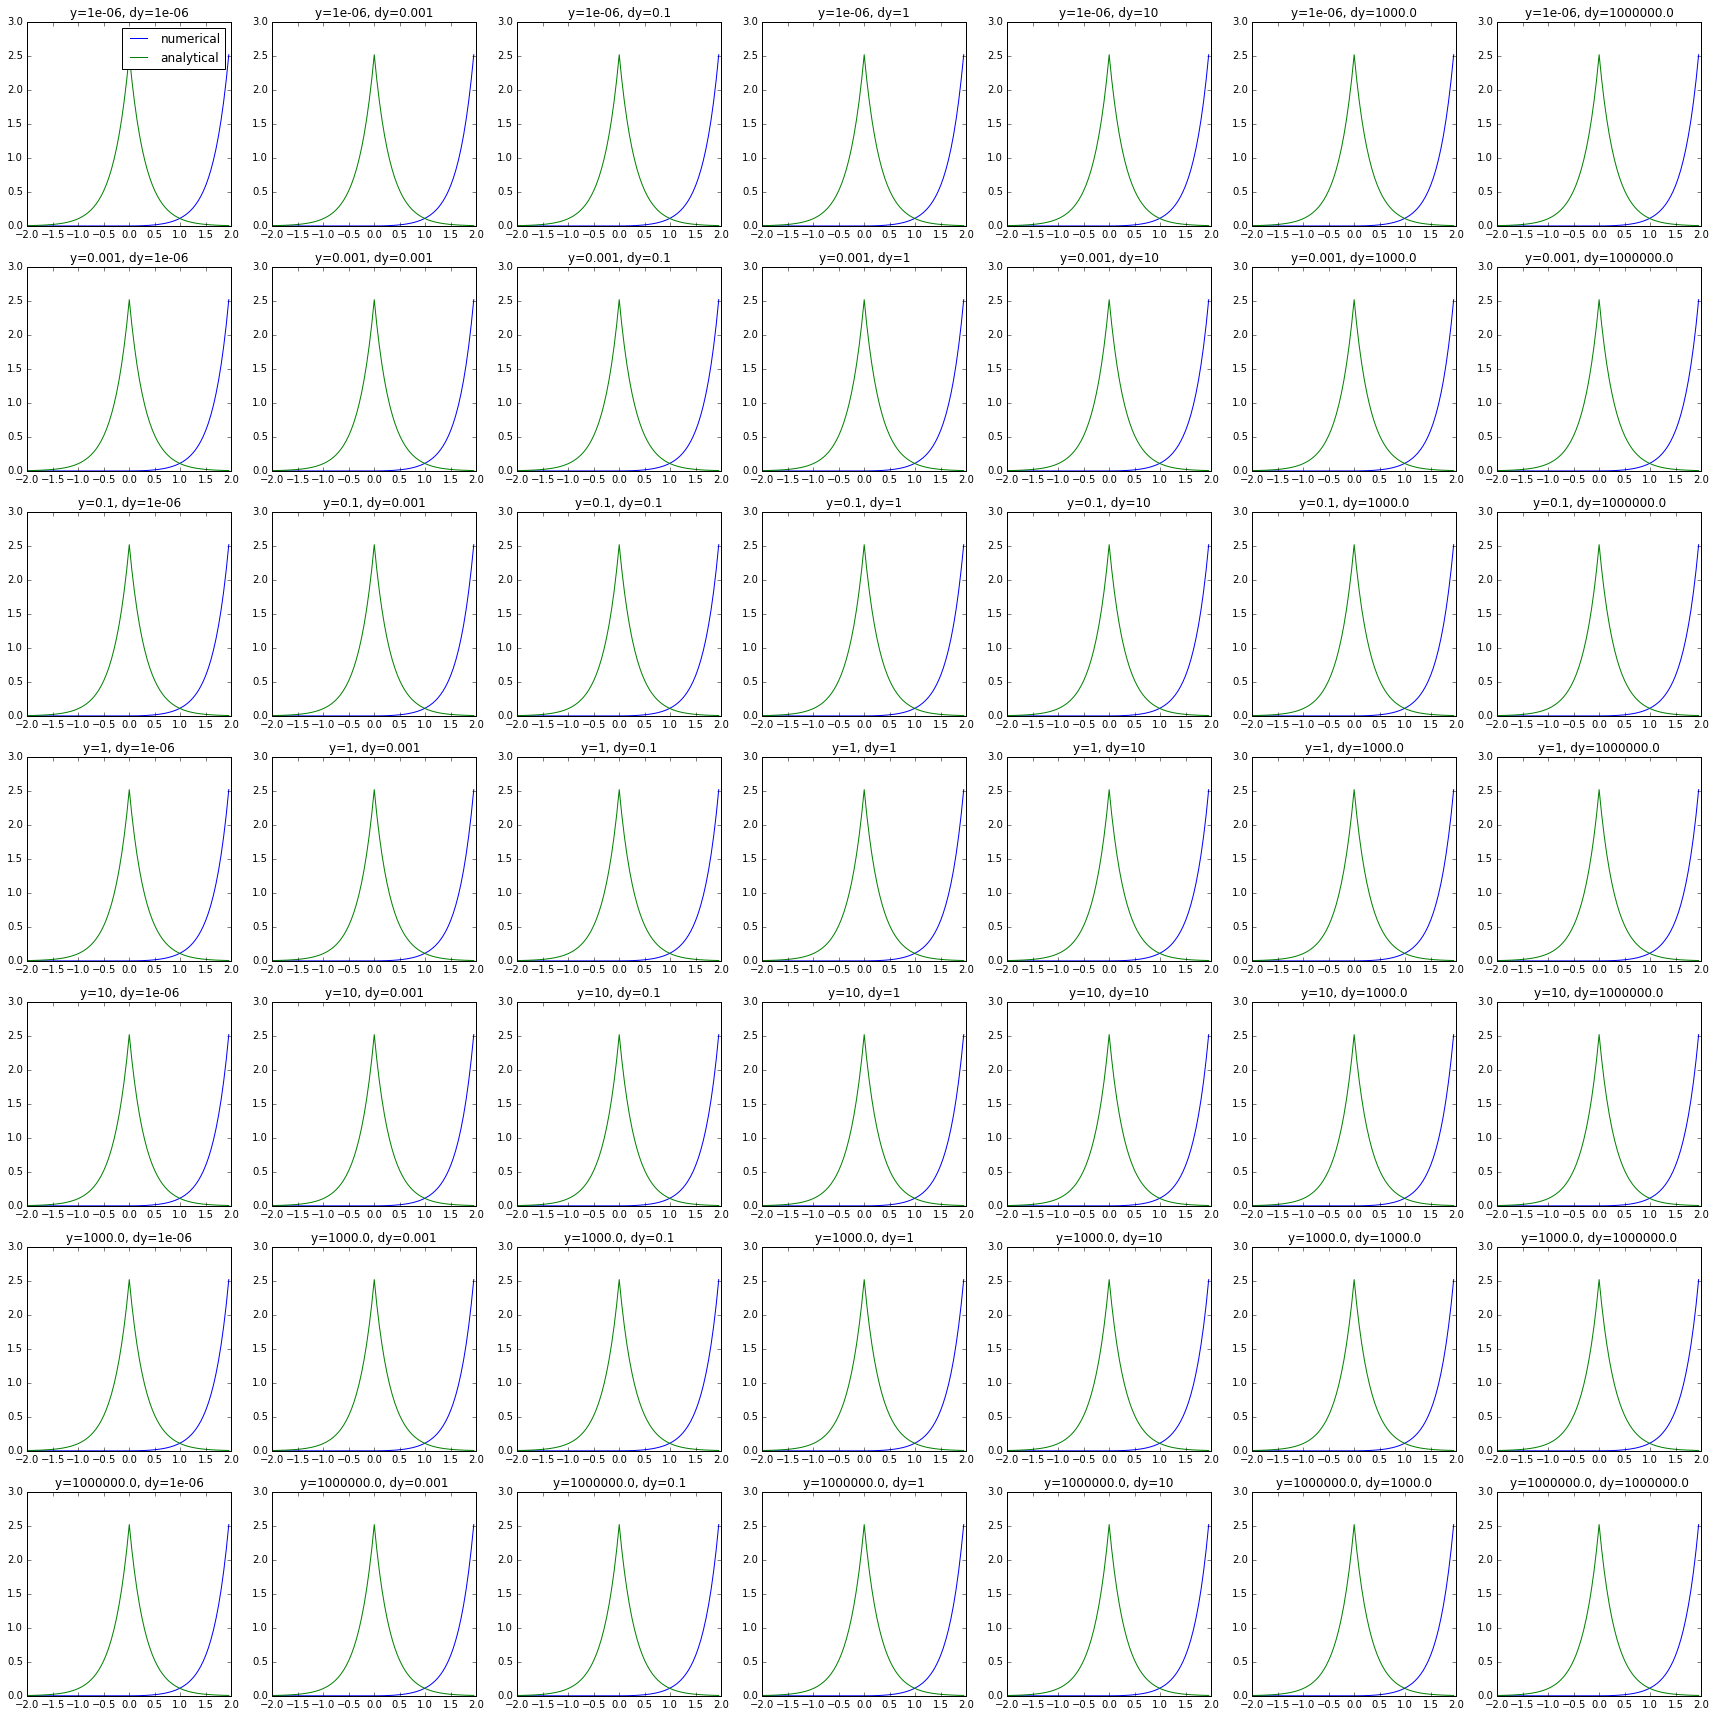

In [95]:
fig, ax = plt.subplots(7,7, figsize=(30,30))
values = [1e-6, 1e-3, 0.1, 1, 10, 1e3, 1e6]
x = np.arange(-2,2,0.05) # cm
for i,y in enumerate(values):
    for j,dy in enumerate(values):
        v = odeint(steady_cable_equation, (0,0), x) 
        v = v / v[-1] * B
        v_analytical = analytical_steady_cable(x)
        ax[i,j].plot(x,v[:,0], label='numerical')
        ax[i,j].plot(x, v_analytical, label='analytical')
        ax[i,j].set_title('y={}, dy={}'.format(y,dy))
ax[0,0].legend()

In [81]:
# ie_inject = lambda x: if x==0: return 1. else: return 0
def ie_inject(x, inject_pos=0., ie=1.):
    return ie if x<inject_pos else 0.

def steadyCableEquation(v0, dvdx0, pos=(-2,2), dx=0.01, rL=200., 
                        eL=-54.502, rm=20., a=2., ie_pos=0., ie=1.):
    """Numerically integrates the expIF neuron membrane equation with the Euler-Method.
    
    The neurons obey a reset rule, when the membrane potential crosses `Vt`
    it is set back to `Vr`.
    
    :param V: array of initial membrane values (or a scalar)
    :param VT: spiking threshold (scalar)
    :param I: array oe input currents (or scalar)
    :param duration: duration of experiment (scalar)
    :param dt: stepsize of Euler integration (scalar)
    
    :return:
    
        2D array of voltage time series, first dimension the neurons, 
        second dimension the voltage trace. 
        First entries contain the initial values.
        
        1D array of simulation times
    
    """
    
    steps = int(float(pos[1]-pos[0])/dx) # Calculate the number of simulation steps
    
    if np.isscalar(v0): # V can be scalar or an array, we need to check first
        nneurons = 1
    else:
        nneurons = len(v0) # Infer the number of neurons from the length of the initial conditions
        
    v = np.zeros((nneurons, steps+1)) # Array that will contain the voltage traces
    dvdx = np.zeros((nneurons, steps+1))
    # 1st dim neurons, 2nd dim voltage traces
    # i.e. V[2,10] would return the voltage of neuron #2 at the 10th timestep!
    # Wee need steps+1 since the 0th entry should contain the initial conditions
    
    x = np.arange(pos[0],pos[1],dx)
    v[:, 0] = v0 # Set initial conditions
    dvdx[:, 0] = dvdx0
    
    positions = np.zeros(steps+1) # Array of positions
    positions[0] = pos[0]
    
    for step in range(1, steps+1): # Loop starting from step 1 (0th contains initial conditions)
        
        IE = ie_inject(positions[step-1], inject_pos=ie_pos, ie=ie)
        dvdx[:,step] = dvdx[:,step-1] + 2*rL/a* (v[:,step-1]-eL)/rm * dx
        v[:,step] = v[:,step-1] + (dvdx[:,step-1] + IE*2*rL/a) * dx
        positions[step] = positions[step-1] + dx
        
    return v, positions


In [22]:
v2,x2 = steadyCableEquation(0., 0.)
v2 = v2 / v2[0,-1] * B

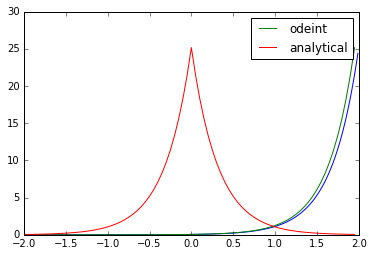

In [23]:
plt.plot(x2[:-1],v2[0][:-1])
plt.plot(x,v[:,0], label='odeint')
plt.plot(x,v_analytical, label='analytical')
plt.legend()